In [1]:
import importlib
import fastai
import os

In [3]:
from fastai.vision.all import *
from shutil import copyfile

In [4]:
ml_data_path = os.path.join(os.path.abspath(os.getcwd()),"../ML/Data")

In [5]:
path = Path(ml_data_path)

oil_chps = np.loadtxt(path/'oil_chps.txt', dtype=str)
codes = np.loadtxt(path/'codes-nocoincident.txt', dtype=str)
valid_names = np.loadtxt(path/'valid_names.txt', dtype=str)

In [6]:
import skimage.io as skio
import numpy as np

labels = path/"lbl"
labels_no_3 = path/"lbl_no3"

os.makedirs(labels_no_3, exist_ok=True)

vals = set()
for i in labels.glob("*.png"):
    arr = skio.imread(i)
    values = np.unique(arr)
    arr[arr==3] = 0
    skio.imsave(labels_no_3 / i.name, arr, check_contrast=False)

In [7]:
random.seed(42)
oilless_chps = [chp for chp in get_image_files(path/'chp') if chp.stem not in oil_chps]
density = 0
num_oilless = density * len(oil_chps)
mixed_chps = random.sample(oilless_chps,num_oilless) + [path/'chp'/(chp+'.png') for chp in oil_chps]
len(mixed_chps)

473

In [8]:
def get_chps(path): return mixed_chps
def get_lbls(fn): return fn.parent.parent/"lbl_no3"/f"{fn.name}"
def splitter_func(fn): return fn.name.rsplit('_',1)[0] in valid_names # XXX Check to make sure this should be returning True for Valid

drive_files = get_chps(path)

In [9]:
lcl = Path("../out_data")
path.mkdir(exist_ok=True)
modelpath = lcl

use_lcl = False
if use_lcl:
  path = lcl
  lcl_chp = path/"chp"
  lcl_lbl = path/"lbl_no3"
  lcl_chp.mkdir(exist_ok=True)
  lcl_lbl.mkdir(exist_ok=True)
  for i, f in enumerate(drive_files): # 10 minutes?!
    if not i%50: print(i, f)
    if not (lcl_chp/f.name).exists():
      copyfile(f, lcl_chp/f.name)
    if not (lcl_lbl/f.name).exists():
      copyfile(get_lbls(f), lcl_lbl/f.name)

In [12]:
seg_db = DataBlock(
    blocks=(ImageBlock, MaskBlock(codes=codes)),
    get_items = get_chps,
    splitter=FuncSplitter(splitter_func),
    batch_tfms=augs,
    get_y=get_lbls)

In [13]:
dls = SegmentationDataLoaders.from_dblock(
    dblock = seg_db,
    source = path,
    path = path,
    bs = 4)

/home/rave/miniconda3/envs/fastai2/lib/python3.9/site-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)
/home/rave/miniconda3/envs/fastai2/lib/python3.9/site-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /opt/c

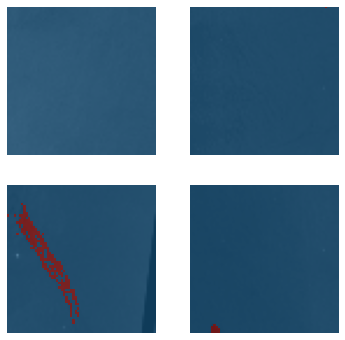

In [14]:
dls.show_batch(vmin=0, vmax=3)

In [15]:
# add best model callback saver
# write to drive not lcl

In [16]:
arch = 18
archs = {18: resnet18, 34: resnet34, 50: resnet50}

In [17]:
learn = unet_learner(dls, archs[arch], metrics=[Dice()], model_dir=modelpath, cbs=[MixedPrecision])

SuggestedLRs(valley=0.00015848931798245758)

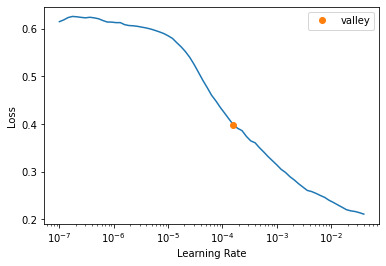

In [18]:
learn.lr_find()

In [19]:
learn.fine_tune(5, 2e-4)#, cbs=SaveModelCallback(monitor='dice'))

epoch,train_loss,valid_loss,dice,time
0,0.076517,0.041192,0.000000,00:05


epoch,train_loss,valid_loss,dice,time
0,0.029031,0.035402,0.000000,00:06
1,0.025283,0.028970,0.043871,00:06
2,0.022743,0.026429,0.339275,00:06
3,0.020582,0.024505,0.331167,00:05
4,0.019285,0.024911,0.274623,00:05


In [20]:
# learn.load("model")

In [21]:
learn

In [20]:
savename = f'{density}_{arch}_{size}_{round(learn.validate()[1],3)}.pkl'
learn.export(modelpath/savename)

PicklingError: Can't pickle torch.half: attribute lookup half on __main__ failed

In [35]:
learn.show_results(max_n=4, figsize=(20,20), vmin=0, vmax=3)

ValueError: This DataLoader does not contain any batches

In [ ]:
from google.colab import files
files.download(modelpath/savename) 

In [36]:
learn.show_results??

Signature: learn.show_results(ds_idx=1, dl=None, max_n=9, shuffle=True, **kwargs)
Docstring: Show some predictions on `ds_idx`-th dataset or `dl`
Source:   
    def show_results(self, ds_idx=1, dl=None, max_n=9, shuffle=True, **kwargs):
        if dl is None: dl = self.dls[ds_idx].new(shuffle=shuffle)
        b = dl.one_batch()
        _,_,preds = self.get_preds(dl=[b], with_decoded=True)
        self.dls.show_results(b, preds, max_n=max_n, **kwargs)
File:      ~/miniconda3/envs/fastai2/lib/python3.9/site-packages/fastai/learner.py
Type:      method


In [39]:
dls[1].new(shuffle=True).one_batch()

(TensorImage([[[[-2.1179, -2.1179, -2.0939,  ..., -0.8902, -0.8852, -0.8646],
           [-2.1179, -2.1179, -2.0932,  ..., -0.8596, -0.8521, -0.8905],
           [-2.1179, -2.1179, -2.0946,  ..., -0.8620, -0.8779, -0.8588],
           ...,
           [-2.1179, -2.1179, -2.0974,  ..., -0.7646, -1.0601, -0.7248],
           [-2.1179, -2.1179, -2.0998,  ..., -0.6994, -0.7162, -0.7148],
           [-2.1179, -2.1179, -2.0990,  ..., -0.7117, -0.6505, -0.7169]],
 
          [[-2.0357, -2.0357, -2.0112,  ..., -0.7806, -0.7755, -0.7544],
           [-2.0357, -2.0357, -2.0105,  ..., -0.7494, -0.7416, -0.7809],
           [-2.0357, -2.0357, -2.0119,  ..., -0.7518, -0.7680, -0.7485],
           ...,
           [-2.0357, -2.0357, -2.0147,  ..., -0.6522, -0.9543, -0.6116],
           [-2.0357, -2.0357, -2.0172,  ..., -0.5855, -0.6027, -0.6013],
           [-2.0357, -2.0357, -2.0164,  ..., -0.5982, -0.5356, -0.6034]],
 
          [[-1.8044, -1.8044, -1.7800,  ..., -0.5549, -0.5499, -0.5288],
        